In [1]:
%matplotlib inline

In [2]:
import xarray as xr
from datatree import DataTree
from pathlib import Path
import pandas as pd
from dask.diagnostics import ProgressBar
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import cartopy.crs as ccrs
import valenspy as vp
from valenspy.diagnostic.visualizations import _add_features
from valenspy.diagnostic.functions import root_mean_square_error

git_dir = Path(os.popen("git rev-parse --show-toplevel").read().strip())

/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [3]:
from valenspy.input.unit_converter import CORDEX_VARIABLES

User options

In [4]:
# Load data options
variables = ["tas"]  # "pr", "tasmin", "tasmax"
period = [1980, 2019]

# Plotting options - to be moved to a seperate "config" file
## Use the seaborn-v0_8-deep style?

mpl.rc('axes',edgecolor='grey')
mpl.rc('axes',labelcolor='dimgrey')
mpl.rc('axes',titlesize=14)
mpl.rc('axes',labelsize=10)
mpl.rc('axes', titlelocation="right")
mpl.rc('xtick',color='dimgrey')
mpl.rc('xtick',labelsize=10)
mpl.rc('ytick',color='dimgrey')
mpl.rc('ytick',labelsize=10)
mpl.rc('legend',fontsize='large')
mpl.rc('legend',frameon=False)
mpl.rc('text',color='dimgrey')
mpl.rc('figure', titlesize=16)


## Specify colors for the specific models
color_dict = {
    "/RCM/ERA5/ALARO1_SFX"          : "blue",
    "/RCM/ERA5/CCLM6-0-1-URB-ESG"   : "red",
    "/RCM/ERA5/MAR"                 : "green",
    "/obs/CLIMATE_GRID"             : "black"
}

d_cmap_diverging = { "tas": 'RdBu_r', "tasmax":'RdBu_r', "tasmin":'RdBu_r', "pr": 'BrBG' }

# Diagnostic switches

## Model2Self
do_AnnualCycle = True
do_TimeSeries = True
do_TimeSeriesUkkel = True
do_Trends = True
do_SpatialMean = True
## Model2Ref
do_SpatialBias = True


#Add iteration over the variables that we would like to be plotted.
#Add color maps per diagnostic
#Add option for season

STEP 1: Load the data

In [5]:
manager = vp.InputManager(machine="hortense")

# ALARO (Using the catalog and the variables userinput)

df_alaro = pd.read_csv("/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/ValEnsPy/CORDEX_eval_scripts/catalog.csv")
df_alaro = df_alaro[df_alaro['frequency'] == 'day']
df_alaro = df_alaro[df_alaro['variable_id'].isin(variables)]
df_alaro

#Load all the paths in the df into one xarray dataset
ds_alaro = xr.open_mfdataset(df_alaro['path'].values, decode_coords='all', chunks="auto")
ds_alaro

## (Requires user adjustment)
# COSMO (Using the input manager - currently variables loaded manually)
experiment      = "CB2_CCLM_BEL28_ERA5_evaluation"
ds_cclm_tas     = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "mean"])
# ds_cclm_tasmax  = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "max"]).rename({'tas':'tasmax'})
# ds_cclm_tasmin  = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "min"]).rename({'tas':'tasmin'})
# ds_cclm_pr      = manager.load_data("CCLM", ["pr"], freq="daily", path_identifiers=[experiment, "sum"])
# ds_cclm         = xr.merge([ds_cclm_tas, ds_cclm_pr, ds_cclm_tasmax, ds_cclm_tasmin])
#del ds_cclm_tas , ds_cclm_pr, ds_cclm_tasmax, ds_cclm_tasmin
ds_cclm = ds_cclm_tas

## (Requires user adjustment)
# MAR (Placeholder for MAR data - for plotting purposes)
ds_mar = ds_alaro

# Observational data
## CLIMATE_GRID (Regridded data)

ds_ref = manager.load_data("CLIMATE_GRID", variables, path_identifiers=["regridded"])

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1999.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1993.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2002.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2012.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1991.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1985.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/dail

Create a DataTree object

In [6]:
## (Requires user adjustment)
data_dict = {
    "RCM/ERA5/ALARO1_SFX": ds_alaro,
    "RCM/ERA5/CCLM6-0-1-URB-ESG": ds_cclm,
    "RCM/ERA5/MAR": ds_mar,
    "obs/CLIMATE_GRID": ds_ref
}

dt = DataTree.from_dict(data_dict)

STEP 2: Preprocessing the data

In [7]:
#Regid to CLIMATE_GRID
dt["RCM"] = dt["RCM"].map_over_subtree(vp.remap_xesmf, dt.obs.CLIMATE_GRID.to_dataset(), method="conservative", regridding_kwargs={"keep_attrs": True})

#Select the time period from period[0] to period[1] (inclusive)
dt = dt.sel(time=slice(f"{period[0]}-01-01", f"{period[1]}-12-31"))

STEP 3: Diagnostics

In [8]:
from valenspy.diagnostic import AnnualCycle
from valenspy.diagnostic import TimeSeriesSpatialMean
from valenspy.diagnostic import TimeSeriesTrendSpatialMean
from valenspy.diagnostic import SpatialBias

Model2Self

Annual Cycle

In [16]:
if do_AnnualCycle:
    with ProgressBar():
        dt_annual_cycle = AnnualCycle(dt).compute()

[########################################] | 100% Completed | 30.81 s
[########################################] | 100% Completed | 10.24 s
[########################################] | 100% Completed | 33.61 s
[########################################] | 100% Completed | 3.96 ss


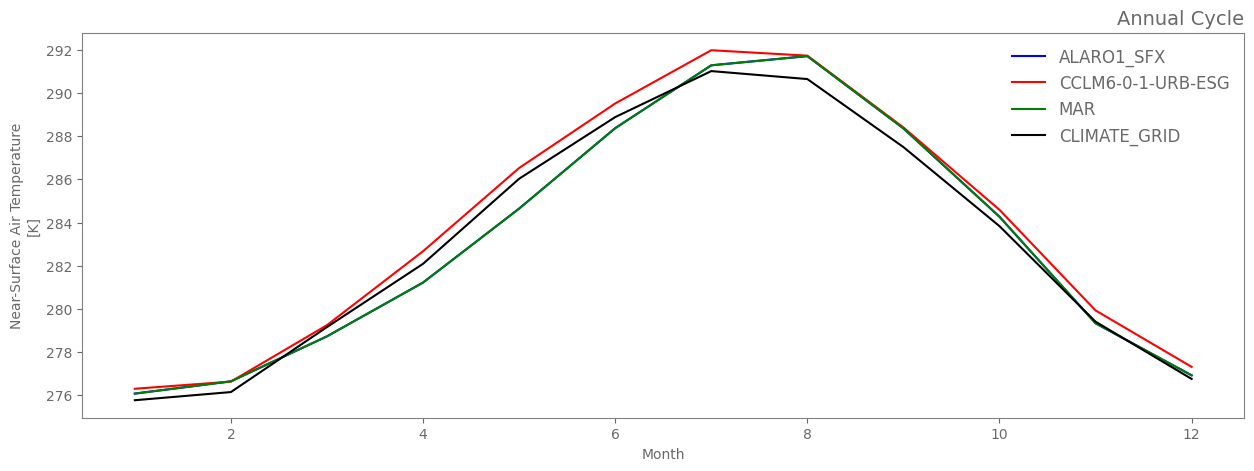

In [18]:
if AnnualCycle:
    fig, ax = plt.subplots(figsize=(15, 5))
    AnnualCycle.plot_dt(dt_annual_cycle, var="tas", ax=ax, label="name", colors=color_dict)
    plt.legend()
    plt.savefig(git_dir / "CORDEX_eval_scripts/plots/Bel_mean_annual_cycle.png")

TimeSeries

In [19]:
if do_TimeSeries:
    heat_wave=["1997-06-01", "1997-08-31"]
    with ProgressBar():
        dt_time_series = dt.sel(time=slice(heat_wave[0], heat_wave[1]))
        dt_time_series = TimeSeriesSpatialMean(dt_time_series).compute()

[########################################] | 100% Completed | 1.30 ss
[########################################] | 100% Completed | 315.91 ms
[########################################] | 100% Completed | 405.83 ms
[########################################] | 100% Completed | 1.95 ss


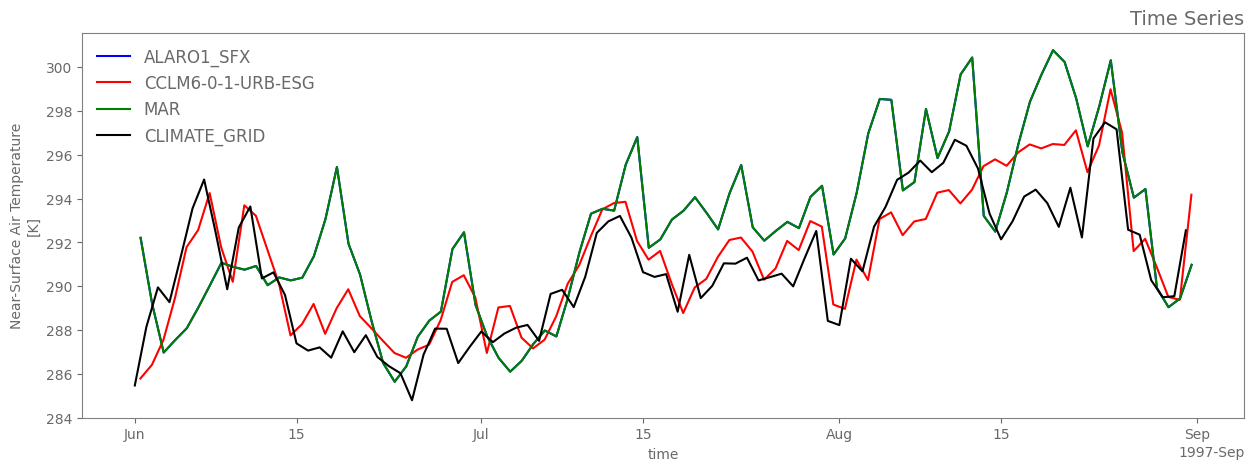

In [20]:
if do_TimeSeries:
    fig, ax = plt.subplots(figsize=(15, 5))
    TimeSeriesSpatialMean.plot_dt(dt_time_series, var="tas", ax=ax, label="name", colors=color_dict)
    plt.legend()
    plt.savefig(git_dir / "CORDEX_eval_scripts/plots/Bel_mean_heat_wave.png")

TimeSeries (Ukkel)

In [22]:
if do_TimeSeriesUkkel:
    Ukkel = (4.37, 50.79)
    heat_wave=["1997-06-01", "1997-08-31"]
    with ProgressBar():
        dt_ukkel_hw = dt.map_over_subtree(vp.select_point, Ukkel[0], Ukkel[1]).sel(time=slice(heat_wave[0], heat_wave[1]))
        dt_time_series_uccle = TimeSeriesSpatialMean(dt_ukkel_hw).compute()

[########################################] | 100% Completed | 1.13 ss
[########################################] | 100% Completed | 303.55 ms
[########################################] | 100% Completed | 404.27 ms
[########################################] | 100% Completed | 523.31 ms


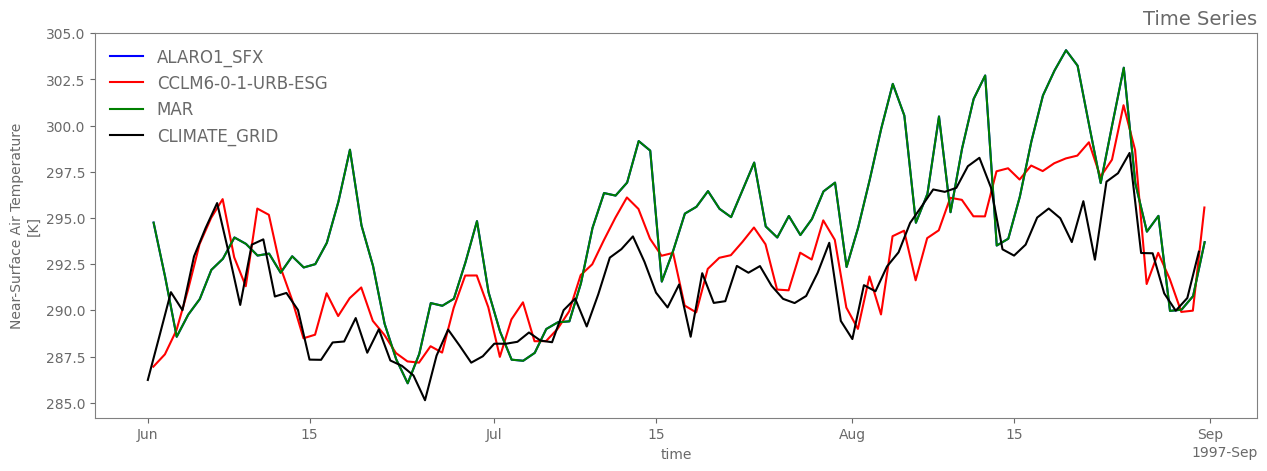

In [23]:
if do_TimeSeriesUkkel:
    fig, ax = plt.subplots(figsize=(15, 5))
    TimeSeriesSpatialMean.plot_dt(dt_time_series_uccle, var="tas", ax=ax, label="name", colors=color_dict)
    plt.legend()
    plt.savefig(git_dir / "CORDEX_eval_scripts/plots/Ukkel_heat_wave.png")

Trends

In [25]:
if do_Trends:
    Ukkel = (4.37, 50.79)
    dt_Ukkel = dt.map_over_subtree(vp.select_point, Ukkel[0], Ukkel[1])
    dt_Ukkel = dt_Ukkel - dt_Ukkel.sel(time=slice("1980-01-01", "1985-12-31")).mean("time")
    with ProgressBar():
        dt_trends = TimeSeriesTrendSpatialMean(dt_Ukkel, window_size=366*5).compute()

[########################################] | 100% Completed | 28.23 s
[########################################] | 100% Completed | 8.85 ss
[########################################] | 100% Completed | 33.08 s
[########################################] | 100% Completed | 938.58 ms


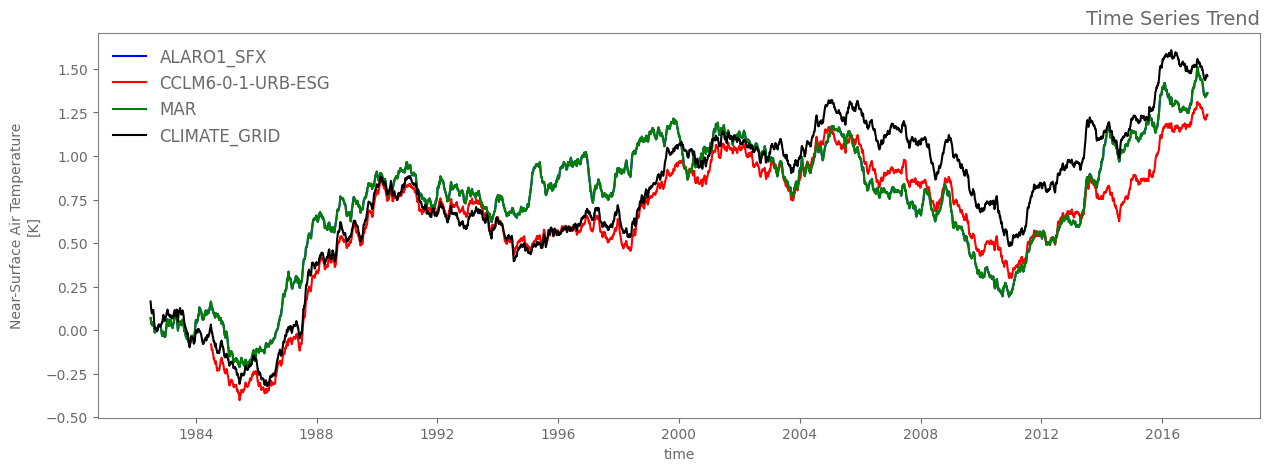

In [26]:
if do_Trends:
    fig, ax = plt.subplots(figsize=(15, 5))
    TimeSeriesTrendSpatialMean.plot_dt(dt_trends, var="tas", ax=ax, label="name", colors=color_dict)
    plt.legend()
    plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/Uccle_time_series_trend_normalized.png")

Model2Ref

SpatialBias

In [9]:
if do_SpatialBias:
    with ProgressBar():
        ds_ref = dt.obs.CLIMATE_GRID.to_dataset()
        dt_spatial_bias = SpatialBias(dt.RCM, ref=ds_ref).compute()

[########################################] | 100% Completed | 38.46 s
[########################################] | 100% Completed | 11.69 s
[########################################] | 100% Completed | 32.31 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


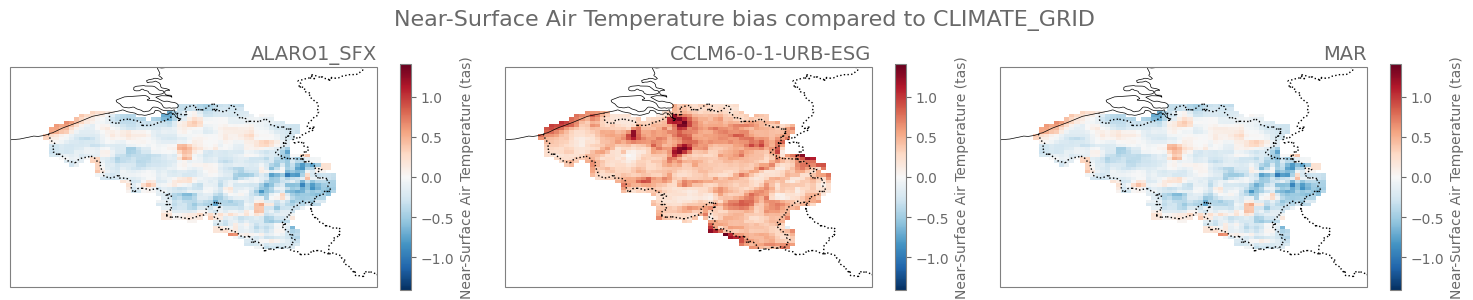

In [10]:
if do_SpatialBias:
    for var in variables:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
        axes = axes.flatten()
        cbar_kwargs={"shrink": 0.52}

        min = np.max([dt[var].values for dt in dt_spatial_bias.max().leaves])
        max = np.min([dt[var].values for dt in dt_spatial_bias.min().leaves])

        v_value = np.max([np.abs(min), np.abs(max)])

        for ax, dt_leave in zip(axes, dt_spatial_bias.leaves):
            SpatialBias.plot(dt_leave[var], ax=ax, cmap=d_cmap_diverging[var], cbar_kwargs=cbar_kwargs, vmin=-v_value, vmax=v_value)
            ax.set_title(dt_leave.name)
            #ax.set_title(' ')
            _add_features(ax, region='belgium')

        fig.suptitle(f'{CORDEX_VARIABLES[var]["long_name"]} bias compared to CLIMATE_GRID', y=0.8)
        fig.tight_layout()
        plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/spatialbias_{var}.png")

/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


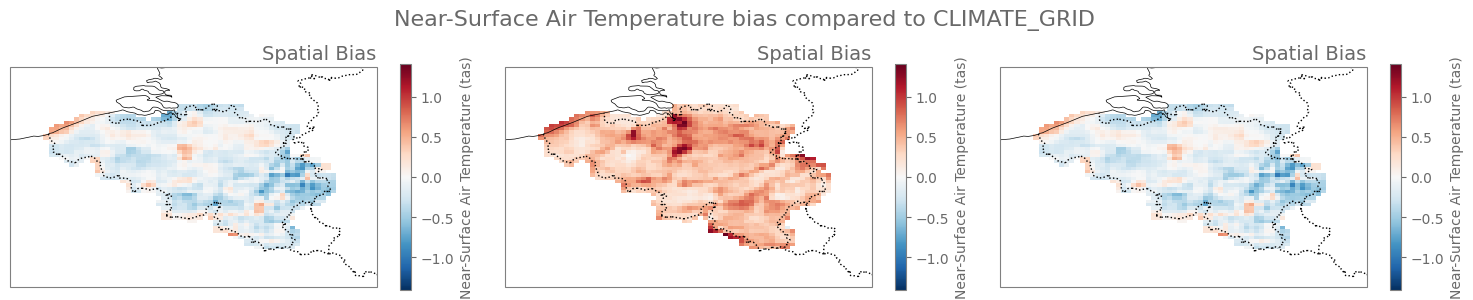

In [14]:
if SpatialBias:
#Plot option 2
    for var in variables:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
        axes = axes.flatten()
        cbar_kwargs={"shrink": 0.52}

        SpatialBias.plot_type = "facetted"

        SpatialBias.plot_dt(dt_spatial_bias, var=var, axes=axes, shared_cbar="abs", label="name", cbar_kwargs=cbar_kwargs, cmap=d_cmap_diverging[var])
        
        for ax in axes:
            _add_features(ax, region='belgium')

        fig.suptitle(f'{CORDEX_VARIABLES[var]["long_name"]} bias compared to CLIMATE_GRID', y=0.8)
        fig.tight_layout()
        plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/spatialbias_{var}.png")

[########################################] | 100% Completed | 30.42 s
[########################################] | 100% Completed | 9.54 ss
[########################################] | 100% Completed | 29.66 s
[########################################] | 100% Completed | 4.26 sms


NameError: name 'get_dt_overall_min_max' is not defined

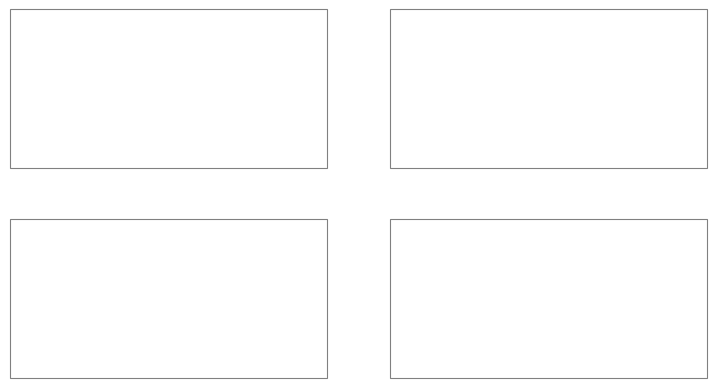

In [14]:
  
## SpatialMean
if do_SpatialMean:
    d_cmap_sequential = {
    "tas": 'YlOrRd',
    "tasmax": 'YlOrRd',
    "tasmin": 'YlOrRd',
    "pr": 'YlGnBu' }
    with ProgressBar():
        dt_spatial_mean = dt.mean(dim="time")
        dt_spatial_mean = dt_spatial_mean.compute()

    #User input (size of the plots)
    fig, axes = plt.subplots(2,2,figsize=(9,5), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()

    # get overall min and max
    overall_min, overall_max = get_dt_overall_min_max(dt_timmean, variable)

    # loop over datasets to do plotting
    for i, dt_leave in enumerate(dt_timmean.leaves):
        ax = axes[i]
        ds = dt_leave.to_dataset()
        ds[variable].plot(ax=ax, cmap=d_cmap_sequential[variable], vmin=overall_min, vmax=overall_max)
        ax.set_title(dt_leave.name, loc='right')
        ax.set_title(' ')
        _add_features(ax, region='belgium')

    fig.suptitle(f'{ds[variable].long_name} ({ds[variable].units})', fontsize=16)

    fig.tight_layout()
    # Mean maps
    plt.savefig(f"/dodrio/scratch/users/vsc31332/rmi/vsc31332_inne/ValEnsPy/CORDEX_eval_scripts/plots/timmean_{variable}_{averaging_period}.png")


In [ ]:
## SpatialMean
if SpatialMean:
    d_cmap_sequential = {
    "tas": 'YlOrRd',
    "tasmax": 'YlOrRd',
    "tasmin": 'YlOrRd',
    "pr": 'YlGnBu' }
    with ProgressBar():
        dt_spatial_mean = dt.mean(dim="time")
        dt_spatial_mean = dt_spatial_mean.compute()

    #User input (size of the plots)
    fig, axes = plt.subplots(2,2,figsize=(9,5), subplot_kw={"projection": ccrs.PlateCarree()})
    axes = axes.flatten()

    # get overall min and max
    overall_min, overall_max = get_dt_overall_min_max(dt_timmean, variable)

    # loop over datasets to do plotting
    for i, dt_leave in enumerate(dt_timmean.leaves):
        ax = axes[i]
        ds = dt_leave.to_dataset()
        ds[variable].plot(ax=ax, cmap=d_cmap_sequential[variable], vmin=overall_min, vmax=overall_max)
        ax.set_title(dt_leave.name, loc='right')
        ax.set_title(' ')
        _add_features(ax, region='belgium')

    fig.suptitle(f'{ds[variable].long_name} ({ds[variable].units})', fontsize=16)

    fig.tight_layout()
    # Mean maps
    plt.savefig(f"/dodrio/scratch/users/vsc31332/rmi/vsc31332_inne/ValEnsPy/CORDEX_eval_scripts/plots/timmean_{variable}_{averaging_period}.png")
